## Task and Approach:

We need to work on the MovieLens dataset and build a model to recommend movies to the end users

In [1]:
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline  

import seaborn as sns 

from sklearn.metrics.pairwise import cosine_similarity  
from scipy import sparse 
from scipy.sparse.linalg import svds 

import warnings  
warnings.filterwarnings("ignore")

In [2]:
import os
path = '/home/srgrace/genericContest_data/Recommender_System/'

Rating = pd.read_csv(os.path.join(path, 'Ratings.csv')) 
Movie_D = pd.read_csv(os.path.join(path, 'Movie details.csv'),encoding='latin-1') 
User_Info = pd.read_csv(os.path.join(path, 'user level info.csv'),encoding='latin-1') 


In [3]:
Rating.head()

,user id,item id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
Movie_D.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1-Jan-95,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),1-Jan-95,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),1-Jan-95,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),1-Jan-95,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),1-Jan-95,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:
User_Info.head()

,user id,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [7]:
# item id in Rating is actually the movie id

Rating.columns = ['user_id', 'movie_id', 'rating', 'timestamp'] 
Rating.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [8]:
print(Rating.shape, Movie_D.shape, User_Info.shape)

(100000, 4) (1682, 24) (943, 5)


In [9]:
Movie_D.columns = ['movie_id', 'movie_title', 'release_date', 'video_release_date ',
       'IMDb_URL', 'unknown', 'Action ', 'Adventure', 'Animation',
       'Childrens', 'Comedy ', 'Crime ', ' Documentary ', 'Drama',
       ' Fantasy', 'Film-Noir ', 'Horror ', 'Musical', 'Mystery',
       ' Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

To get our desired information in a single dataframe, we can merge the two dataframes objects on the movie_Id column since it is common between the two dataframes.

We can do this using merge() function from the Pandas library

In [10]:
Movie_Rating = pd.merge(Rating ,Movie_D,on = 'movie_id')
Movie_Rating.describe()

,user_id,movie_id,rating,timestamp,video_release_date,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
count,100000.00000,100000.000000,100000.000000,1.000000e+05,0.0,100000.0000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.00000,100000.000000,100000.000000
mean,462.48475,425.530130,3.529860,8.835289e+08,NaN,0.0001,0.255890,0.137530,0.036050,0.071820,...,0.013520,0.017330,0.053170,0.049540,0.052450,0.194610,0.12730,0.21872,0.093980,0.018540
std,266.61442,330.798356,1.125674,5.343856e+06,NaN,0.0100,0.436362,0.344408,0.186416,0.258191,...,0.115487,0.130498,0.224373,0.216994,0.222934,0.395902,0.33331,0.41338,0.291802,0.134894
min,1.00000,1.000000,1.000000,8.747247e+08,NaN,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
25%,254.00000,175.000000,3.000000,8.794487e+08,NaN,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
50%,447.00000,322.000000,4.000000,8.828269e+08,NaN,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
75%,682.00000,631.000000,4.000000,8.882600e+08,NaN,0.0000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
max,943.00000,1682.000000,5.000000,8.932866e+08,NaN,1.0000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000


We can see the Average rating for all the movie is 3.5
We can also see 25 percentile also indicating avaerage is 3 highest is 5

In [12]:
# No of unique users & No of unique Movies

n_users = Movie_Rating.user_id.unique().shape[0]
n_items = Movie_Rating.movie_id.unique().shape[0]
print(n_items,n_users)

1682 943


In [13]:
# Calculate mean rating of all movies 

Movie_Stats = pd.DataFrame(Movie_Rating.groupby('movie_title')['rating'].mean())
Movie_Stats.sort_values(by = ['rating'],ascending=False).head()

,rating
movie_title,
They Made Me a Criminal (1939),5.0
Marlene Dietrich: Shadow and Light (1996),5.0
"Saint of Fort Washington, The (1993)",5.0
Someone Else's America (1995),5.0
Star Kid (1997),5.0


In [14]:
# Calculate count rating of all movies 

Movie_Stats['Count_of_ratings'] = pd.DataFrame(Movie_Rating.groupby('movie_title')['rating'].count())
Movie_Stats.sort_values(by =['Count_of_ratings'], ascending=False).head()

,rating,Count_of_ratings
movie_title,,
Star Wars (1977),4.358491,583
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485


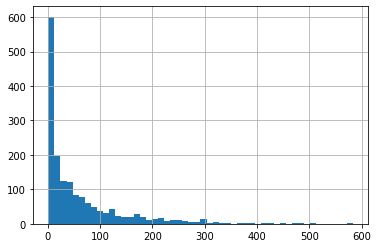

In [15]:
Movie_Stats['Count_of_ratings'].hist(bins=50)


From the output, you can see that most of the movies have received less than 50 ratings. It is evident that the data has a weak normal distribution with the mean of around 3.5. There are a few outliers in the data

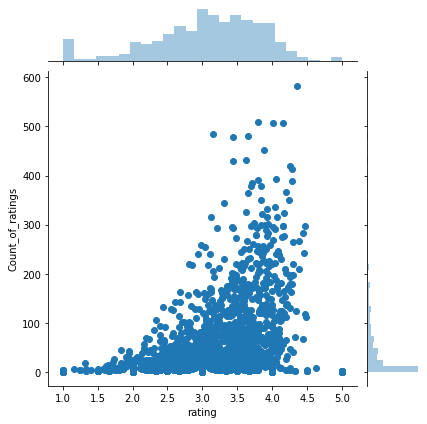

In [17]:
sns.jointplot(x='rating', y='Count_of_ratings', data=Movie_Stats)


* The graph shows that, in general, movies with higher average ratings actually have more number of ratings, compared with movies that have lower average ratings.

## Finding Similarities Between Movies

* We will use the correlation between the ratings of a movie as the similarity metric.
* To see the correlation we will create Pivot table between user_id ,movies, ratings

In [18]:
User_movie_Rating = Movie_Rating.pivot_table(index='user_id', columns='movie_title', values='rating')
User_movie_Rating.head()

movie_title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,2.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN


In [19]:
# We can achieve this by computing the correlation between these two movies ratings and the ratings of the rest 
# of the movies in the dataset. The first step is to create a dataframe with the ratings of these movies 

# Example pick up one movie related rating  
User_movie_Rating['Air Force One (1997)']

user_id
1      NaN
2      4.0
3      2.0
4      5.0
5      NaN
6      NaN
7      4.0
8      NaN
9      NaN
10     NaN
11     3.0
12     4.0
13     1.0
14     NaN
15     4.0
16     5.0
17     NaN
18     NaN
19     NaN
20     NaN
21     3.0
22     NaN
23     NaN
24     4.0
25     NaN
26     4.0
27     NaN
28     NaN
29     3.0
30     NaN
      ... 
914    NaN
915    3.0
916    NaN
917    NaN
918    NaN
919    4.0
920    3.0
921    NaN
922    NaN
923    NaN
924    2.0
925    NaN
926    3.0
927    5.0
928    NaN
929    NaN
930    4.0
931    5.0
932    NaN
933    NaN
934    NaN
935    4.0
936    3.0
937    4.0
938    3.0
939    NaN
940    5.0
941    4.0
942    5.0
943    NaN
Name: Air Force One (1997), Length: 943, dtype: float64

## Correlation Similarity

We can find the correlation between the user ratings for the given movie and all the other movies using corrwith() function as shown below:

In [20]:
Similarity = User_movie_Rating.corrwith(User_movie_Rating['Air Force One (1997)'])
Similarity.head()

movie_title
'Til There Was You (1997)    0.867722
1-900 (1994)                      NaN
101 Dalmatians (1996)        0.221943
12 Angry Men (1957)          0.228031
187 (1997)                   0.294232
dtype: float64

In [21]:
corr_similar = pd.DataFrame(Similarity, columns=['Correlation'])
corr_similar.sort_values(['Correlation'], ascending= False).head(10)

,Correlation
movie_title,
Love and Death on Long Island (1997),1.0
Losing Chase (1996),1.0
Phat Beach (1996),1.0
My Crazy Life (Mi vida loca) (1993),1.0
Tetsuo II: Body Hammer (1992),1.0
Jack and Sarah (1995),1.0
Vermin (1998),1.0
Faster Pussycat! Kill! Kill! (1965),1.0
For Ever Mozart (1996),1.0


#### We will add the count of rating also to see why many movies are exactly correlating for the single movie

In [22]:
corr_similar_num_of_rating = corr_similar.join(Movie_Stats['Count_of_ratings'])
corr_similar_num_of_rating.sort_values(['Correlation'], ascending= False).head(10)

,Correlation,Count_of_ratings
movie_title,,
Love and Death on Long Island (1997),1.0,2
Losing Chase (1996),1.0,8
Phat Beach (1996),1.0,5
My Crazy Life (Mi vida loca) (1993),1.0,11
Tetsuo II: Body Hammer (1992),1.0,6
Jack and Sarah (1995),1.0,7
Vermin (1998),1.0,2
Faster Pussycat! Kill! Kill! (1965),1.0,7
For Ever Mozart (1996),1.0,3


* We can able to see that a movie cannot be declared similar to the another movie based on just 2 or 3 ratings.

* This is why we need to filter movies correlated to given movie that have more than 30/50 ratings

In [23]:
corr_similar_num_of_rating[corr_similar_num_of_rating ['Count_of_ratings'] > 50].sort_values('Correlation', 
                                                                                           ascending=False).head()


,Correlation,Count_of_ratings
movie_title,,
Air Force One (1997),1.000000,431
Black Sheep (1996),0.766259,55
Copycat (1995),0.711744,86
Tales from the Crypt Presents: Bordello of Blood (1996),0.639372,55
Addicted to Love (1997),0.576379,54


* Create the user defined function to get the similar movies to recommend

* All the above steps created as one UDF so that we can pass the movie title and get the recomendations

In [25]:
def get_recommendations(title):
    # Get the movie ratings of the movie that matches the title
    Movie_rating = User_movie_Rating[title]

    # Get the  similarity corrilated  scores of all movies with that movie
    sim_scores = User_movie_Rating.corrwith(Movie_rating)

    # Sort the movies based on the similarity scores
    corr_title = pd.DataFrame(sim_scores, columns=['Correlation'])
    
    # Removing na values 
    corr_title.dropna(inplace=True)
    
    corr_title = corr_title.join(Movie_Stats['Count_of_ratings'])
    
    # Return the top 10 most similar movies
    return corr_title[corr_title ['Count_of_ratings'] > 50].sort_values('Correlation', ascending=False).head(10)

In [26]:
# Usage of the above function
get_recommendations('Air Force One (1997)')


,Correlation,Count_of_ratings
movie_title,,
Air Force One (1997),1.000000,431
Black Sheep (1996),0.766259,55
Copycat (1995),0.711744,86
Tales from the Crypt Presents: Bordello of Blood (1996),0.639372,55
Addicted to Love (1997),0.576379,54
Mary Shelley's Frankenstein (1994),0.564120,59
Weekend at Bernie's (1989),0.557623,60
"Grand Day Out, A (1992)",0.557278,66
"Hunt for Red October, The (1990)",0.554383,227


In [27]:
get_recommendations('Star Wars (1977)')


,Correlation,Count_of_ratings
movie_title,,
Star Wars (1977),1.000000,583
"Empire Strikes Back, The (1980)",0.747981,367
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Giant (1956),0.488093,51
"Life Less Ordinary, A (1997)",0.411638,53
Austin Powers: International Man of Mystery (1997),0.377433,130
"Sting, The (1973)",0.367538,241
Indiana Jones and the Last Crusade (1989),0.350107,331


## Cosine Similarties

* Untill now we have seen the correlation wise now we are going to use cosine similariy to find the similar movies
* Filter out required columns from the dataset

In [28]:
Movie_cosine = Movie_Rating[['user_id','movie_id','rating']]
Movie_cosine.head()

,user_id,movie_id,rating
0,196,242,3
1,63,242,3
2,226,242,5
3,154,242,3
4,306,242,5


* Sparse matrix we are going to create using above data
* A sparse matrix in Coordinate format this is also called as triplet format

In [29]:
data = Movie_cosine.rating
col = Movie_cosine.movie_id
row = Movie_cosine.user_id

R = sparse.coo_matrix((data, (row, col))).tocsr()
print(R)
print('{0}x{1} user by movie matrix'.format(*R.shape))

  (1, 1)	5
  (1, 2)	3
  (1, 3)	4
  (1, 4)	3
  (1, 5)	3
  (1, 6)	5
  (1, 7)	4
  (1, 8)	1
  (1, 9)	5
  (1, 10)	3
  (1, 11)	2
  (1, 12)	5
  (1, 13)	5
  (1, 14)	5
  (1, 15)	5
  (1, 16)	5
  (1, 17)	3
  (1, 18)	4
  (1, 19)	5
  (1, 20)	4
  (1, 21)	1
  (1, 22)	4
  (1, 23)	4
  (1, 24)	3
  (1, 25)	4
  :	:
  (943, 739)	4
  (943, 756)	2
  (943, 763)	4
  (943, 765)	3
  (943, 785)	2
  (943, 794)	3
  (943, 796)	3
  (943, 808)	4
  (943, 816)	4
  (943, 824)	4
  (943, 825)	3
  (943, 831)	2
  (943, 840)	4
  (943, 928)	5
  (943, 941)	1
  (943, 943)	5
  (943, 1011)	2
  (943, 1028)	2
  (943, 1044)	3
  (943, 1047)	2
  (943, 1067)	2
  (943, 1074)	4
  (943, 1188)	3
  (943, 1228)	3
  (943, 1330)	3
944x1683 user by movie matrix


* Keeping data ,col, row we call it as Triplet Format of Matrix

* The individual elements of the matrix can be listed in any order, and if there are multiple items for the same nonzero position, the values provided for those positions are added.

* Using the cosine similarity to measure the similarity between a pair of vectors

* With the cosine similarity, we are going to evaluate the similarity between two vectors based on the angle between them. The smaller the angle, the more similar the two vectors are

* If you recall from trigonometry, the range of the cosine function goes from -1 to 1. Some important properties of cosine to recall:

    Cosine(0°) = 1 <br>
    Cosine(90°) = 0 <br>
    Cosine(180°) = -1 <br>
    
    
* If we restrict our vectors to non-negative values (as in the case of movie ratings, usually going from a 1-5 scale), then the angle of separation between the two vectors is bound between 0° and 90°

In [30]:
find_similarities = cosine_similarity(R.T) # We are transposing the matrix 
print(find_similarities)
print(find_similarities.shape)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.40238218 ... 0.         0.04718307 0.04718307]
 [0.         0.40238218 1.         ... 0.         0.07829936 0.07829936]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.04718307 0.07829936 ... 0.         1.         0.        ]
 [0.         0.04718307 0.07829936 ... 0.         0.         1.        ]]
(1683, 1683)


In [31]:
def Get_Top5_Similarmovies(model, movie_id, n=5):
    return model[movie_id].argsort()[::-1][:n].tolist()  # Here movie id is index

In [32]:
# index is started with 0 and movie id is started with 1
Movie_D.head()


,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1-Jan-95,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),1-Jan-95,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),1-Jan-95,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),1-Jan-95,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),1-Jan-95,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [33]:
# e.g: idx 4 means movie_id=5
Movie_D.iloc[4] 

movie_id                                                               5
movie_title                                               Copycat (1995)
release_date                                                    1-Jan-95
video_release_date                                                   NaN
IMDb_URL               http://us.imdb.com/M/title-exact?Copycat%20(1995)
unknown                                                                0
Action                                                                 0
Adventure                                                              0
Animation                                                              0
Childrens                                                              0
Comedy                                                                 0
Crime                                                                  1
 Documentary                                                           0
Drama                                              

In [34]:
Movie_D.iloc[Get_Top5_Similarmovies(find_similarities, 4)]


,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
4,5,Copycat (1995),1-Jan-95,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
56,57,Priest (1994),1-Jan-94,NaN,http://us.imdb.com/M/title-exact?Priest%20(1994),0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
204,205,Patton (1970),1-Jan-70,NaN,http://us.imdb.com/M/title-exact?Patton%20(1970),0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
174,175,Brazil (1985),1-Jan-85,NaN,http://us.imdb.com/M/title-exact?Brazil%20(1985),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
202,203,Unforgiven (1992),1-Jan-92,NaN,http://us.imdb.com/M/title-exact?Unforgiven%20...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Matrix Factorization
### Singular Value Decomposition (Matrix Factorization)
* df_array=UΣVT
 
Now using Singular Value Decomposition, we will decompose our dataframe into smaller matrices. This can be done directly with the help of scipy using scipy.sparse.linalg.svds.


For Matrix factorization, we need normalized values.

In [36]:
df_matrix = User_movie_Rating.fillna(0)
df_matrix.head()

movie_title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,2.0,5.0,0.0,0.0,3.0,4.0,0.0,0.0,...,0.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0


In [37]:
normalized_values = df_matrix.values - np.mean(df_matrix.values, axis=1).reshape(-1,1)
normalized_values

array([[-0.58713942, -0.58713942,  1.41286058, ..., -0.58713942,
         3.41286058, -0.58713942],
       [-0.13581731, -0.13581731, -0.13581731, ..., -0.13581731,
        -0.13581731, -0.13581731],
       [-0.08834135, -0.08834135, -0.08834135, ..., -0.08834135,
        -0.08834135, -0.08834135],
       ...,
       [-0.05348558, -0.05348558, -0.05348558, ..., -0.05348558,
        -0.05348558, -0.05348558],
       [-0.19951923, -0.19951923, -0.19951923, ..., -0.19951923,
        -0.19951923, -0.19951923],
       [-0.34435096, -0.34435096, -0.34435096, ..., -0.34435096,
        -0.34435096, -0.34435096]])

In [38]:
U, SIGMA, VT = svds(normalized_values)
U.shape, SIGMA.shape, VT.shape

((943, 6), (6,), (6, 1664))

In [41]:
# Since SIGMA is not the same shape as U or VT, we make it into a diagonal matrix.

SIGMA = np.diag(SIGMA)
U.shape, SIGMA.shape, VT.shape


((943, 6), (6, 6), (6, 1664))

Now we can see the values of  U,Σ,V . Notice that  Σ  is a diagonal matrix now.

In [44]:
reconstructed_df = np.dot(np.dot(U, SIGMA), VT) + np.mean(df_matrix.values, axis=1).reshape(-1, 1)
predictions_df = pd.DataFrame(reconstructed_df, columns = df_matrix.columns)
predictions_df

movie_title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
0,-0.008376,0.040828,0.255097,1.368637,0.086250,1.412191,0.490817,3.157662,-0.027797,0.324986,...,-0.028977,-0.003432,-0.017040,2.536312,1.662737,0.666667,0.670269,-0.049776,0.129188,-0.005724
1,0.038789,-0.044555,0.326952,0.133404,0.342076,0.530822,-0.318530,-0.024044,-0.020123,-0.082302,...,-0.040017,0.011209,-0.040759,-0.255696,-0.368808,-0.202552,0.224910,-0.004341,-0.026679,-0.021383
2,0.051939,0.008640,-0.154229,0.001675,0.373526,0.077553,-0.027438,0.008863,0.028092,-0.041838,...,0.014913,0.061333,0.014861,-0.246739,0.130785,0.059758,0.094154,-0.002092,0.058520,0.020152
3,0.016714,-0.009719,-0.007841,0.027480,0.235820,0.077210,0.039097,0.119632,0.002121,0.006895,...,-0.006565,0.021345,-0.004972,-0.104974,0.088231,0.028096,0.038567,-0.010205,0.026276,-0.005262
4,0.039749,0.064445,0.482236,0.667350,-0.026506,0.372200,0.780897,1.681404,0.040625,0.334868,...,0.051029,0.034790,0.060711,1.524330,1.131505,0.499319,0.068121,0.048664,0.122230,0.039145
5,-0.023912,0.062152,0.128513,2.703320,0.013552,0.331147,0.816331,4.292271,0.013495,1.800758,...,-0.012645,0.052678,-0.005738,2.683918,-0.455536,-0.391933,0.368426,0.012802,-0.055008,0.012775
6,0.250950,0.322421,0.703982,3.608192,0.209865,0.182696,2.468875,6.333909,0.279539,2.404307,...,0.274461,0.327062,0.290763,4.853118,1.677596,0.666046,0.239397,0.251226,0.320476,0.263086
7,-0.086035,-0.017031,-0.015568,0.420149,0.067936,0.177707,0.542724,1.479968,-0.048712,0.336866,...,-0.049041,-0.048124,-0.037303,0.822997,0.700829,0.260260,0.031982,-0.063608,0.042233,-0.059207
8,0.002741,0.005160,0.073705,0.228515,0.063128,0.096191,0.060185,0.381519,0.003139,0.167317,...,-0.001956,0.008569,-0.000422,0.159217,-0.091958,-0.058400,0.054529,0.006922,0.000296,0.000781
9,-0.027215,0.076606,-0.192344,2.496347,0.055766,0.401753,0.770103,4.213219,0.016694,1.571815,...,-0.005529,0.060076,0.001638,2.675330,0.055610,-0.138218,0.448404,-0.016026,0.001819,0.020638


As you can see above, the predictions_df shows values of ratings very close to the actual ratings given by users to the movies in the df_matrix dataframe. The remaining values in predictions_df of which corresponding cells are 0 in df_matrix, are the predicted ratings from the multiplication of the factors that we decomposed the df_matrix into.


Let's create some helper functions to find out what a user's ratings and the genres which the user rates the highest.

In [45]:
def get_genres(in_df):
    df1 = in_df.iloc[:, 5:24]
    df1 = df1.eq(1).dot(' ' + df1.columns.values).apply(lambda x: x.replace(' ', '|').replace('|', '', 1))
    return df1

def user_ratings(user_id, df):
    df1 = df[df['user_id'] == user_id].sort_values(['rating'], ascending=False).copy()
    df2 = get_genres(df1)
    df3 = pd.concat([df1[['movie_title', 'rating']], df2], axis=1)
    df3 = df3.rename(columns = {0:'genres'})
    return df3

Now let's see what the user id = 100 likes.

In [46]:
user_ratings(100, Movie_Rating)


,movie_title,rating,genres
80568,Titanic (1997),5,Action||Drama||Romance
74972,As Good As It Gets (1997),5,Comedy||Drama
47235,Apt Pupil (1998),5,Drama
133,L.A. Confidential (1997),4,Crime||Film-Noir||Mystery
39589,Tomorrow Never Dies (1997),4,Action|||Romance
99265,"Big Bang Theory, The (1994)",4,Crime|
92445,Dark City (1998),4,Film-Noir||Sci-Fi
86259,"Replacement Killers, The (1998)",4,Action|
77534,"Postman, The (1997)",4,Drama
76290,Air Force One (1997),4,Action|


We see that user 100 likes a lot of Drama movies. The movies he has rated highest have a Drama element in them.

Now let's write a helper function, to get the recommendations for the user, from the matrix factors that we created earlier.

The process is as follows.

* We select movies which are not rated by the user.
* We merge the resultant (non rated) movies dataframe with the predictions_df matrix on the movie title.
* Now we have the predicted values for the movie ratings.
* We select the movies with the highest predicted ratings, and recommend that to the user.

In [47]:
def get_recommendations(user_id, number_of_recommendations=10):
    df1 = Movie_D[~Movie_D['movie_id'].isin(Movie_Rating[Movie_Rating['user_id'] == user_id] \
                                        .sort_values(['rating'], ascending=False)['movie_id'])] \
                                        .merge(pd.DataFrame(predictions_df.iloc[user_id - 1] \
                                                            .sort_values(ascending=False)) \
                                               .reset_index(), \
                                               how='left', left_on='movie_title', right_on='movie_title') \
                                        .sort_values(user_id - 1, ascending=False) \
                                        .iloc[:number_of_recommendations, :]
    
    df2 = pd.concat([df1[['movie_title']], get_genres(df1)], axis=1)
    
    df2 = df2.rename(columns = {0:'genres'})
    
    return df2

In [48]:
get_recommendations(100)


,movie_title,genres
292,"Devil's Advocate, The (1997)",Crime||Horror||Mystery|Thriller
287,In & Out (1997),Comedy|
711,"Saint, The (1997)",Action|||Romance|Thriller
309,Kiss the Girls (1997),Crime||Drama|Thriller
305,Cop Land (1997),Crime||Drama|Mystery
244,"Devil's Own, The (1997)",Action||Drama|Thriller|War
245,Chasing Amy (1997),Drama||Romance
302,Murder at 1600 (1997),Mystery|Thriller
308,"Edge, The (1997)",Adventure|Thriller
288,Ulee's Gold (1997),Drama


In [49]:
get_recommendations(1)


,movie_title,genres
202,Trainspotting (1996),Drama
45,Schindler's List (1993),Drama|War
382,Stand by Me (1986),Adventure|Comedy||Drama
84,One Flew Over the Cuckoo's Nest (1975),Drama
160,Heathers (1989),Comedy|
3,Leaving Las Vegas (1995),Drama||Romance
0,Heat (1995),Action||Crime||Thriller
150,E.T. the Extra-Terrestrial (1982),Childrens|Drama||Fantasy|Sci-Fi
235,"People vs. Larry Flynt, The (1996)",Drama
201,Dr. Strangelove or: How I Learned to Stop Worr...,Sci-Fi|War
